# Sensibility matrix of eq. layers for gravitational field

This code illustrates the sensibilty matrix associated with the equivalent layer for gravitational field.

### Things we have to import

In [1]:
import numpy as np
from numpy.testing import assert_almost_equal as aae
import matplotlib.pyplot as plt
from gravmag import eqlayer, filters, transforms, convolve
from gravmag.models import rectangular_prism as rp
from gravmag import plot_functions as plf
from gravmag import constants as cts

/home/vanderlei/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Points were we compute the synthetic data

In [2]:
# number of points along x and y
shape = (4, 3)

# minimum x, maximum x, minimum y and maximum y
area = [-5, 5, -4, 6]

# coordinates 
xp = np.linspace(area[0], area[1], shape[0])
yp = np.linspace(area[2], area[3], shape[1])
yp, xp = np.meshgrid(yp, xp)

yp = np.ravel(yp)
xp = np.ravel(xp)

# constant vertical coordinate of the simulated gravity data
z_data = 0

zp = np.zeros_like(yp) + z_data

coordinates = np.vstack([xp, yp, zp])

In [3]:
# Grid spacing
dx = (area[1] - area[0])/(shape[0]-1)
dy = (area[3] - area[2])/(shape[1]-1)

In [4]:
print(dx, dy)

3.3333333333333335 5.0


### Equivalent layer

In [5]:
# gravitational field components
field_names = ['x', 'y', 'z', 'xx', 'xy', 'xz', 'yy', 'yz', 'zz']

In [6]:
symmetries = [
    'skew-symm', 'symm-skew', 'symm-symm',
    'symm-symm', 'skew-skew', 'skew-symm',
    'symm-symm', 'symm-skew',
    'symm-symm'
]

In [13]:
transposition_factors = [-1, -1, 1, 1, 1, -1, 1, -1, 1]

In [7]:
Q = shape[0] # number of blocks along rows/columns
P = shape[1] # number of rows/columns in each block

In [8]:
# layer z
#z_layer = -150 + 2.5*(0.5*(dx+dy))
#z_layer = 2.5*(0.5*(dx+dy))
z_layer = 5

In [9]:
source_points = np.copy(coordinates)
source_points[2] = z_layer

In [10]:
# list for storing the matrices associated with each potential field
matrices = []

for name in field_names:
    # kernel matrix associated with the equivalent layer
    matrix = eqlayer.kernel_matrix_monopoles(coordinates, source_points, field=name)
    matrices.append(matrix/np.max(matrix))

In [11]:
eigenvalues_matrices = []
eigenvalues_transposed_matrices = []

for (matrix, symmetry) in zip(matrices, symmetries):
    # matrices
    c0 = convolve.embedding_BCCB_first_column(
        b0=matrix[:,0], Q=Q, P=P, symmetry=symmetry
    )
    eigenvalues_matrices.append(
        convolve.eigenvalues_BCCB(c0=c0, Q=Q, P=P)
    )
    # transposed matrices
    c0 = convolve.embedding_BCCB_first_column(
        b0=matrix.T[:,0], Q=Q, P=P, symmetry=symmetry
    )
    eigenvalues_transposed_matrices.append(
        convolve.eigenvalues_BCCB(c0=c0, Q=Q, P=P)
    )

In [24]:
vector = np.random.rand(np.prod(shape))
for (name, matrix, eigenvalues_matrix) in zip(field_names, matrices, eigenvalues_matrices):
    result1 = matrix@vector
    result2 = convolve.product_BCCB_vector(L=eigenvalues_matrix, Q=Q, P=P, v=vector)
    print(
        'field {:>3s} is correct:'.format(name), 
        np.allclose(result1, result2)
    )

field   x is correct: True
field   y is correct: True
field   z is correct: True
field  xx is correct: True
field  xy is correct: True
field  xz is correct: True
field  yy is correct: True
field  yz is correct: True
field  zz is correct: True


In [26]:
for (
    name, symmetry, eigenvalues_matrix, eigenvalues_transposed_matrix, transposition_factor
) in zip(
    field_names, symmetries, eigenvalues_matrices, eigenvalues_transposed_matrices, transposition_factors
):
    print(
        'field {:>3} has transposition factor {:>2d}:'.format(name, transposition_factor), 
        np.allclose(eigenvalues_matrix, transposition_factor*eigenvalues_transposed_matrix)
    )

field   x has transposition factor -1: True
field   y has transposition factor -1: True
field   z has transposition factor  1: True
field  xx has transposition factor  1: True
field  xy has transposition factor  1: True
field  xz has transposition factor -1: True
field  yy has transposition factor  1: True
field  yz has transposition factor -1: True
field  zz has transposition factor  1: True


### Plot the results

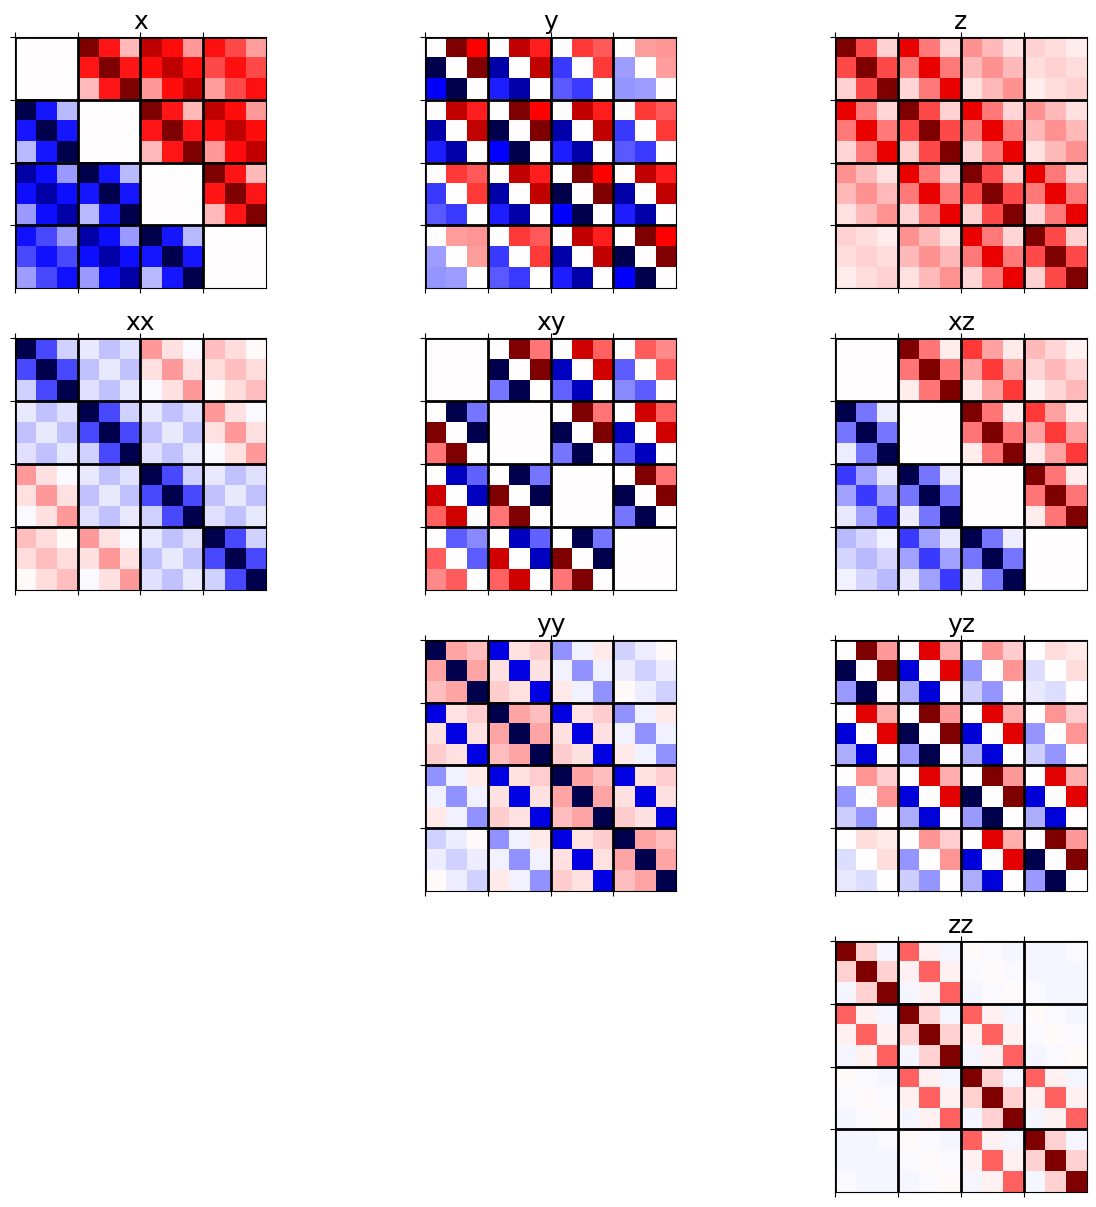

In [27]:
windows = [1, 2, 3, 4, 5, 6, 8, 9, 12]

#fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(15,15))
plt.figure(figsize=(15,15))

for w, window in enumerate(windows):
    
    bound = np.max(np.abs(matrices[w]))
    
    plt.subplot(4, 3, window)
    plt.title(field_names[w], fontsize=18)
    plt.matshow(
        matrices[w], fignum=False, cmap='seismic',
        vmin = -bound, vmax = bound
    )
    #plt.colorbar()
    plt.xticks(ticks=np.arange(Q)*P - 0.5, labels=[])
    plt.yticks(ticks=np.arange(Q)*P - 0.5, labels=[])
    plt.grid(color='k', linewidth=2)